# Column-SQL for analyzing COVID-19 statistics

This notebook demonstrates how **Column-SQL** can be used to perform simple analysis of COVID-19 statistical data.

Contents:
* What is Prosto toolkit
* What is Column-SQL
* Data understanding
* Create a Prosto workflow
* Populate table
* Calculate column
* Project and link column instead of join
* Aggregate column instead of groupby
* Use aggregates in the source table
* Execute the workflow and explore the result
* Summary

## What is Prosto toolkit

**Prosto** is a data processing toolkit radically changing how data is processed by heavily relying on *functions* and *operations with functions* as opposed to using only set operations in traditional approaches like map-reduce or join-groupby.

In **Prosto**, data is inferred using two categories of operations: producing new tables (mathematical sets) and producing new columns (mathematical functions). It is opposed to the classical approach where only set operations are used even if they are not very appropriate. In contrast to traditional approaches, **Prosto** derives new columns from already existing columns (although it also supports table operations).

## What is Column-SQL

**Prosto** data processing toolkit provides two ways to define operations of its workflows:
* Programmatically using function parameters
* Syntactically using **Column-SQL**

Every **Column-SQL** statement starts from the operation name, for example: 
* ``TABLE ...``: table population defining data sources
* ``CALCULATE ...``: define a new derived column
* ``LINK ...``: link two tables by defining a new column
* ``PROJECT ...``: project a table by producing a new table
* ``AGGREGATE ...``: create a new column with aggregated data from another table

Operation name is followed by an arrow (``->``) separated sequence consisting of table or column names. If it is a table name then it may also include a list of columns in parantheses, for example:

``CALCULATE MyTable(column1, column2) -> my_new_calculate_column``

This **Column-SQL** statement will create a new column ``my_new_calculate_column`` in the existing table ``MyTable``. Importantly, the values of this new derived column will be computed from the values in columns ``column1`` and ``column1``. How new values are computed is specified in a Python uesr-defined function (UDF), which is associated with many **Column-SQL** statements when they are added to the workflow:

```python
prosto.column_sql(
    "MyTable(column1, column2) -> my_new_calculate_column", 
    lambda x: x["column1"] + x["column1"]
)
```
Here the new column column is computed as the sum of two source columns. Note that this UDF processes values and not sets. UDFs in **Prosto** are unaware of any collections or loops. It is the task of the system to organize all the computations over multiple tables and columns.

## Data understanding

COVID-19 statistical data is stored in one source table `all-states-history`. For each `date` and `state`, some figures are stored like `death` and `recovered`. Here is an example record: `<"2020-06-23","NE",249,11980>` which means that there were registered 249 deaths and 11980 recovered in Nebraska on June 23, 2020.

Our general goal is to *aggregate* these statistical data for each state. More specifically, The goal is to find mean ratio of `death` to `recovered` for each state over all dates. 

In **Prosto Column-SQL**, we will apply three operations:

* `CALCULATE` column will compute the ratio between `death` and `recovered` by adding a new column to the existing `all-states-history` table
* `PROJECT` operation will produce a `states` table with all states and create a link for the source table to the `states`
* `AGGREGATE` operation will use the previously created link column for grouping and finding mean values of the calculated column by storing the results in a new column in the `states` table

The data and workflow structure are shown in the figure below:

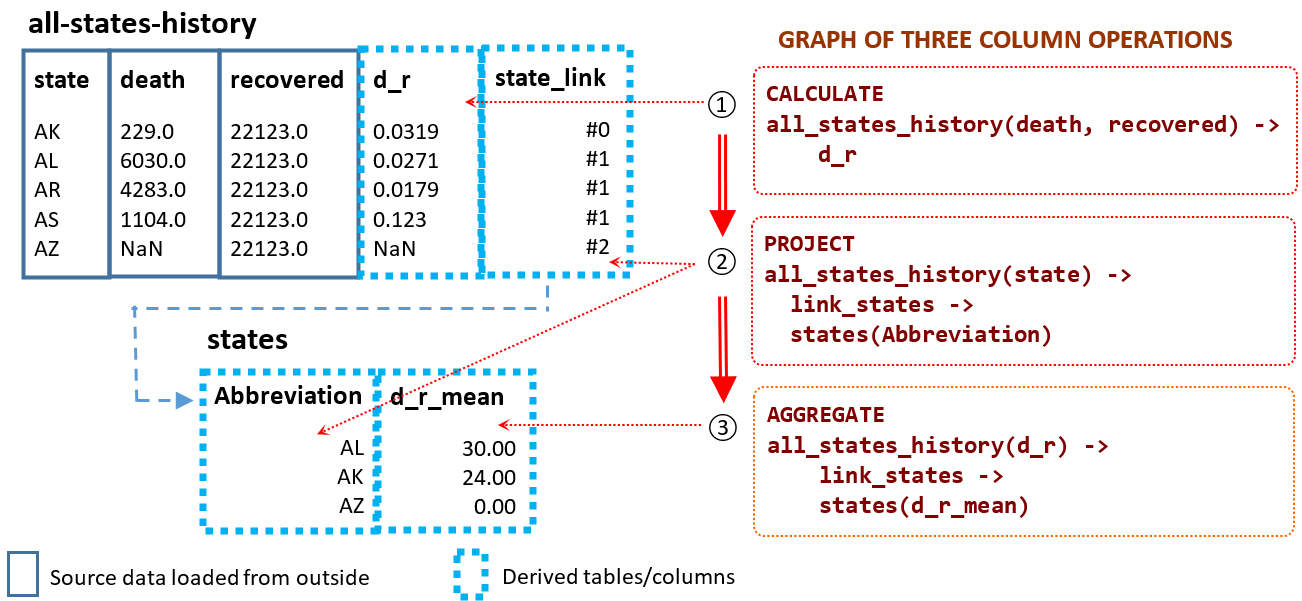

## Create a Prosto workflow

Before we can process data in **Prosto**, it is necessary to create a **Prosto** workflow object which is a context for all other operations.

In [3]:
import pandas as pd  # Prosto relies on pandas
import prosto as pr  # Import Prosto toolkit

# Create a workflow
prosto = pr.Prosto("COVID 19 Data Analysis")
# Element name is stored in the id field
print("Workflow name is: ´{}´".format(prosto.id))

Workflow name is: ´COVID 19 Data Analysis´


## Populate table

Here we define a table with data which is not derived but rather loaded for outside - data frame in this case. Note that we need to execute the workflow in order to show the data.

In [4]:
# Data locations (only one will be used)
all_states_history_url = "https://covidtracking.com/data/download/all-states-history.csv"
all_states_history_file = "./data/all-states-history.csv"

# Load data either from remote (url) or local (file) location. Select only necessary columns
df_all_states_history = pd.read_csv(all_states_history_file, usecols=["date", "state", "death", "recovered"])

prosto.column_sql("TABLE  all_states_history", df_all_states_history)

prosto.run()
prosto.get_table("all_states_history").get_df().head()

,date,state,death,recovered
0,2021-01-15,AK,229.0,7165.0
1,2021-01-15,AL,6030.0,221961.0
2,2021-01-15,AR,4263.0,237729.0
3,2021-01-15,AS,0.0,NaN
4,2021-01-15,AZ,11040.0,89665.0


## Calculate column

Here we want to add a new calculated column the `all_states_history` table. This column (when evaluated) will compute the ratio of `death` to `recovered` for each row. The desired computations are implemented in a user-defined function passed to the operation as lambda. Here again we execute the workflow and then show the result.

In [5]:
prosto.column_sql(
    "CALCULATE all_states_history(death, recovered) -> d_r", 
    lambda x: x["death"] / x["recovered"]
)

prosto.run()
prosto.get_table("all_states_history").get_df().head()

,date,state,death,recovered,d_r
0,2021-01-15,AK,229.0,7165.0,0.0319609
1,2021-01-15,AL,6030.0,221961.0,0.0271669
2,2021-01-15,AR,4263.0,237729.0,0.0179322
3,2021-01-15,AS,0.0,NaN,None
4,2021-01-15,AZ,11040.0,89665.0,0.123125


## Project and link column instead of join

Our goal is to compute aggregates for states but for that purpose we need a table which stores all states. This is  done by projecting the source table `all_states_history`. In addition, the project operation will create a *link* column with references from the source `all_states_history` table to the new project table. This link column will be then used for aggregation.

In this **Column-SQL** query, we first specify the source table name with columns to be projected, then (after arrow) a link column name, and finally a table to be created. After the workflow is executed, we can explore the new table.

In [6]:
prosto.column_sql("PROJECT  all_states_history(state) -> link_states -> states(Abbreviation)")

prosto.run()
prosto.get_table("states").get_df().head()

,Abbreviation
0,AK
1,AL
2,AR
3,AS
4,AZ


## Aggregate column instead of groupby

Here we define a new column in the `states` table. However, its values will be computed by aggregating *groups* of records in the `all_states_history` table. More specifically, for each state, we want to select all statistical records which belong to it via the link column, and then find the mean of the `d_r` column.

Note that the new aggregate column is defined directly in the `states` table and not in a newly generated table like in groupby or reduce. We do not join any tables and we do not produce a new table: the new column is defined directly where it has to be.

The **Column-SQL** query first specifies the existing table with source data to be aggregated (and the column which has to be aggregated), then (after arrow) we specify a link column used for grouping, and finally we specify an existing table with a new aggregate column name.

In [7]:
prosto.column_sql(
    "AGGREGATE  all_states_history(d_r) -> link_states -> states(d_r_mean)",
    lambda x: x.mean()
)

prosto.run()
prosto.get_table("states").get_df().head()

,Abbreviation,d_r_mean
0,AK,0.026810
1,AL,0.040470
2,AR,0.030728
3,AS,0.000000
4,AZ,0.163518


## Use aggregates in the source table

Here we use the aggregates from the `states` table in the source table `all_states_history`. In other words, the data is collected from the source table, stored in aggregated form in another table, and then we again use this data in the source table.

In [8]:
prosto.column_sql(
    "CALCULATE all_states_history(death, recovered, link_states::d_r_mean) -> normalized_d_r", 
    lambda x: (x["death"] + x["recovered"]) / x["link_states::d_r_mean"] if x["link_states::d_r_mean"] != 0 else 0.0
)

prosto.run()
prosto.get_table("all_states_history").get_df().head()

,date,state,death,recovered,d_r,link_states,link_states::d_r_mean,normalized_d_r
0,2021-01-15,AK,229.0,7165.0,0.0319609,0,0.0268105,275788
1,2021-01-15,AL,6030.0,221961.0,0.0271669,1,0.0404698,5.63361e+06
2,2021-01-15,AR,4263.0,237729.0,0.0179322,2,0.0307282,7.87524e+06
3,2021-01-15,AS,0.0,NaN,None,3,0,0
4,2021-01-15,AZ,11040.0,89665.0,0.123125,4,0.163518,615866


## Execute the workflow and explore the result

Normally, we define all operations and execute the workflow only once. Our main result is an aggregate column in the `states` table where we can see mean ratio of `death` to `recovered` for each state.

In [9]:
prosto.run()

display(prosto.get_table("all_states_history").get_df())
display(prosto.get_table("states").get_df())

,date,state,death,recovered,d_r,link_states,link_states::d_r_mean,normalized_d_r
0,2021-01-15,AK,229.0,7165.0,0.0319609,0,0.0268105,275788
1,2021-01-15,AL,6030.0,221961.0,0.0271669,1,0.0404698,5.63361e+06
2,2021-01-15,AR,4263.0,237729.0,0.0179322,2,0.0307282,7.87524e+06
3,2021-01-15,AS,0.0,NaN,None,3,0,0
4,2021-01-15,AZ,11040.0,89665.0,0.123125,4,0.163518,615866
...,...,...,...,...,...,...,...,...
17909,2020-01-17,WA,NaN,NaN,None,52,0,0
17910,2020-01-16,WA,NaN,NaN,None,52,0,0
17911,2020-01-15,WA,NaN,NaN,None,52,0,0
17912,2020-01-14,WA,NaN,NaN,None,52,0,0


,Abbreviation,d_r_mean
0,AK,0.026810
1,AL,0.040470
2,AR,0.030728
3,AS,0.000000
4,AZ,0.163518
5,CA,0.000000
6,CO,0.317048
7,CT,0.523952
8,DC,0.157393
9,DE,0.098682


## Summary

**Columnb-SQL** relies on mathematical functions (implemented as columns) for data processing. This approach in many cases is simpler and more natural. In particular, we do not have to produce new tables (using join or groupby) where it is not necessary and can directly define new columns from data in other columns. The statements of **Column-SQL** are added to the context by defining one complex workflow and the system then executes it by taking into account dependencies between operations. This allows us to express quite complex scenarios of data processing.